In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
from scipy import sparse

In [2]:
import sys; sys.path.append("/home/shhsu/download/scClass")
import scClass
from scClass.main import Model

In [3]:
def dataset(file):
    return"../../../../scClass_dataset/pbmc_scPortal/"+file

path_barcode  = dataset('barcode.txt')
path_gene     = dataset('gene.txt')
path_matrix   = dataset('matrix.txt')
path_metadata = dataset('metadata.txt')

## Matrix Preparation

In [4]:
barcode = pd.read_table(path_barcode,header=None,names=["barcode"])
gene = pd.read_table(path_gene,header=None,names=["ensembl_ids","gene"])
m = pd.read_table(path_matrix,sep=" ").values
matrix = sparse.coo_matrix((m[1:,2], (m[1:,1].astype(np.int32)-1,m[1:,0].astype(np.int32)-1)),shape=(31021,33694))

In [5]:
adata = ad.AnnData(
    X = matrix.tocsc(),
    var = gene,
    obs = barcode
    )

/home/shhsu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
adata = ad.AnnData(
    X = matrix.tocsc(),
    var = gene,
    obs = barcode
    )
select = [("10X_V2" in bar)|("10x_v2" in bar) for bar in adata.obs["barcode"]]
adata = adata[select,:]
adata 

View of AnnData object with n_obs × n_vars = 9806 × 33694
    obs: 'barcode'
    var: 'ensembl_ids', 'gene'

## Label Preparation

In [7]:
# trans_table = np.array([
# ["CD14+ monocyte",10],
# ["CD16+ monocyte",10],
# ["CD4+ T cell",0],
# ["Cytotoxic T cell",1],
# ["Dendritic cell",11],
# ["Plasmacytoid dendritic cell",11],
# ["B cell",3],
# ["Natural killer cell",7],
# ["Megakaryocyte",9],]
# )

In [8]:
metadata = pd.read_table(path_metadata)
metadata = metadata[metadata["Method"].isin(["10x Chromium (v2)","10x Chromium (v2) A","10x Chromium (v2) B"])]

In [9]:
anno = metadata['CellType']

label_y,label2 = np.unique(anno,return_inverse=True)
trans_table = scClass.auto_translabel(label_y)

label = scClass.get_type_id(label=anno,table=trans_table)

,label,index
label,,
naive B cell,B cell,3
monocyte,CD14+ monocyte,10
monocyte,CD16+ monocyte,10
T-helper cell,CD4+ T cell,0
cytotoxic T cell,Cytotoxic T cell,1
dendritic cell,Dendritic cell,11
megakaryocyte,Megakaryocyte,9
natural killer cell,Natural killer cell,7
dendritic cell,Plasmacytoid dendritic cell,11


## Post Preparation

In [10]:
# Transmodel(gene seq)
adata2 = scClass.transmodel(adata,gene=gene["ensembl_ids"],gene_ref='ensembl_ids')
# Normalize
pass    # this data has been normalized

/home/shhsu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


get gene seq...
0% 14% 29% 44% 59% 74% 89% 
Of 33694 genes in the input file, 29202 were found in the training set of 45468 genes.
mapping to model...
0% 

## Classifier

In [11]:
model = scClass.load()

loading model from:  /home/shhsu/download/scClass/scClass/data/model_train_v2.pkl


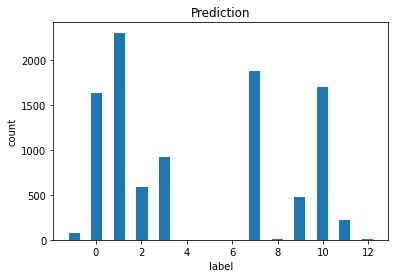

In [12]:
y_pred = scClass.predict_batch(adata2,model)

,label
-1,unknown
0,T-helper cell
1,cytotoxic T cell
2,memory B cell
3,naive B cell
4,plasma cell
5,precursor B cell
6,pro-B cell
7,natural killer cell
8,erythrocyte

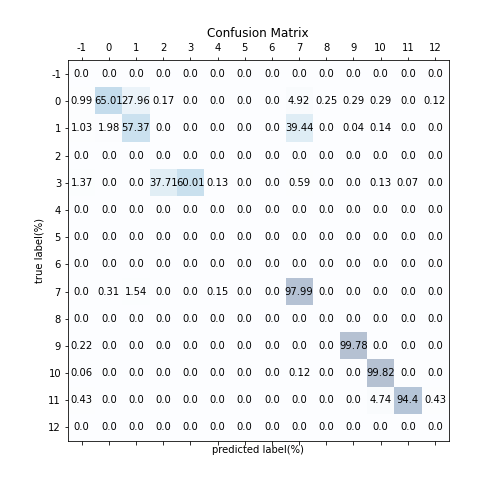

In [13]:
fig = scClass.confusion_matrix(y_pred=y_pred,y_true=label)
scClass.figure_html(fig)

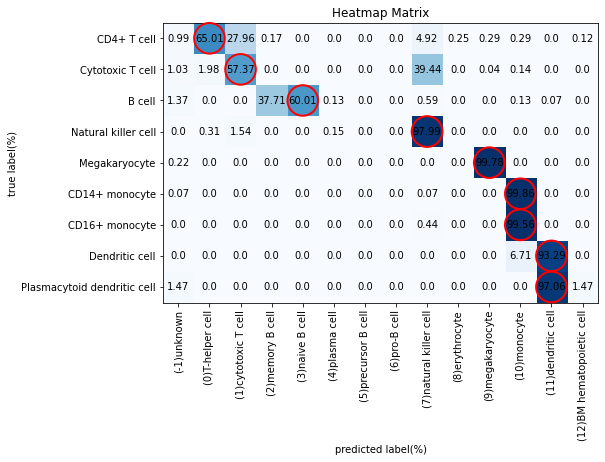

In [14]:
scClass.heatmap_matrix(y_pred=y_pred,y_true=label2,label_y=label_y,table=trans_table)